# Difficulty Classifier for KilterGAN

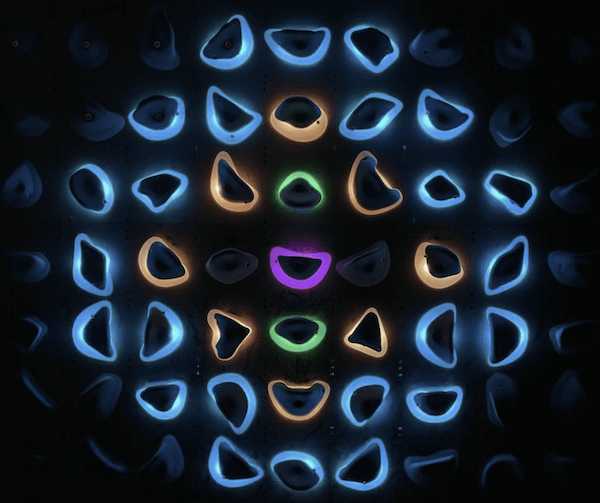

*The EDA showed promise for the degree of separability between route difficulties*

Classification Model

The objective of this notebook is to create a classification model that can differentiate between easier climbs (V1-V3) and harder climbs (V4-V6). This classifier will be used to evaluate the climbs generated by the KilterGAN

---

*Matthew Acs and Richard Acs*

In [2]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 9.8 MB/s eta 0:00:00


In [3]:
import requests
import zipfile
import os
import shutil
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import visualkeras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from tensorflow.keras.utils import plot_model

# Load Data
---
The first step is to load the data from the KilterGAN GitHub repository

In [4]:
# Define the URLs of the GitHub repository zip files
urls = {
    "VDifficult": "https://github.com/matthewaaa123/KilterGAN/raw/main/VDifficult.zip",
    "VEasy": "https://github.com/matthewaaa123/KilterGAN/raw/main/VEasy.zip"
}

# Directory to save and extract the zip files
base_dir = 'KilterGAN/'

# Create the base directory if it doesn't exist
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Function to download and unzip files
def download_and_unzip(name, url):
    zip_file_path = os.path.join(base_dir, f"{name}.zip")
    extraction_dir = os.path.join(base_dir, name)

    # Download the zip file
    response = requests.get(url)
    with open(zip_file_path, 'wb') as file:
        file.write(response.content)
    print(f"Downloaded {zip_file_path}")

    # Create the extraction directory if it doesn't exist
    if not os.path.exists(extraction_dir):
        os.makedirs(extraction_dir)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_dir)
    print(f"Extracted to {extraction_dir}")

    # List the files in the extraction directory
    extracted_files = os.listdir(extraction_dir)
    print(f"Extracted files in {name}:", extracted_files)

# Download and unzip each file
for name, url in urls.items():
    download_and_unzip(name, url)


Downloaded KilterGAN/VDifficult.zip
Extracted to KilterGAN/VDifficult
Extracted files in VDifficult: ['__MACOSX', 'VDifficult']
Downloaded KilterGAN/VEasy.zip
Extracted to KilterGAN/VEasy
Extracted files in VEasy: ['__MACOSX', 'VEasy']


---

The code below cleans up the directories

---

In [5]:
# Base directories
base_dir = '/content/KilterGAN/'
vdifficult_dir = os.path.join(base_dir, 'VDifficult')
veasy_dir = os.path.join(base_dir, 'VEasy')

# Remove __MACOSX directories if they exist
def remove_macosx_dirs(base_path):
    for root, dirs, files in os.walk(base_path):
        for dir_name in dirs:
            if dir_name == "__MACOSX":
                dir_path = os.path.join(root, dir_name)
                print(f"Removing directory: {dir_path}")
                shutil.rmtree(dir_path)

# Move all images to the main difficulty directory
def move_images_to_main_dir(source_dir):
    for root, dirs, files in os.walk(source_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                src_file_path = os.path.join(root, file)
                dst_file_path = os.path.join(source_dir, file)
                shutil.move(src_file_path, dst_file_path)

# Remove now-empty subdirectories
def remove_empty_subdirs(directory):
    for root, dirs, files in os.walk(directory):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            if not os.listdir(dir_path):
                print(f"Removing empty directory: {dir_path}")
                os.rmdir(dir_path)

# Execute the cleanup process
remove_macosx_dirs(base_dir)
move_images_to_main_dir(vdifficult_dir)
move_images_to_main_dir(veasy_dir)
remove_empty_subdirs(vdifficult_dir)
remove_empty_subdirs(veasy_dir)

# Print completion message
print("Cleanup process completed successfully!")


Removing directory: /content/KilterGAN/VEasy/__MACOSX
Removing directory: /content/KilterGAN/VDifficult/__MACOSX
Removing empty directory: /content/KilterGAN/VEasy/VEasy/V2
Removing empty directory: /content/KilterGAN/VEasy/VEasy/V3
Removing empty directory: /content/KilterGAN/VEasy/VEasy/V1
Cleanup process completed successfully!


---

The code below prepares the images for classification

---

In [6]:
# Base directories
base_dir = '/content/KilterGAN/'
vdifficult_dir = os.path.join(base_dir, 'VDifficult/VDifficult')
veasy_dir = os.path.join(base_dir, 'VEasy/VEasy')

# Function to get image file paths
def get_image_file_paths(directory):
    image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.gif']
    image_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if os.path.splitext(file)[1].lower() in image_extensions:
                image_files.append(os.path.join(root, file))
    return image_files

# Get image file paths for each difficulty level
veasy_levels = ['V1', 'V2', 'V3']
vdifficult_levels = ['V4', 'V5', 'V6']

vdifficult_images = {level: get_image_file_paths(os.path.join(vdifficult_dir, level)) for level in vdifficult_levels}
veasy_images = {level: get_image_file_paths(os.path.join(veasy_dir, level)) for level in veasy_levels}


# Classifier for (128, 128)
---

The next step is to create a CNN to classify the data as easier or harder routes. This section uses the original 128 * 128 images

---

The code below defines the CNN architecture

---

In [7]:
# Function to create the model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

---

The code below visualizes the CNN architecture

---

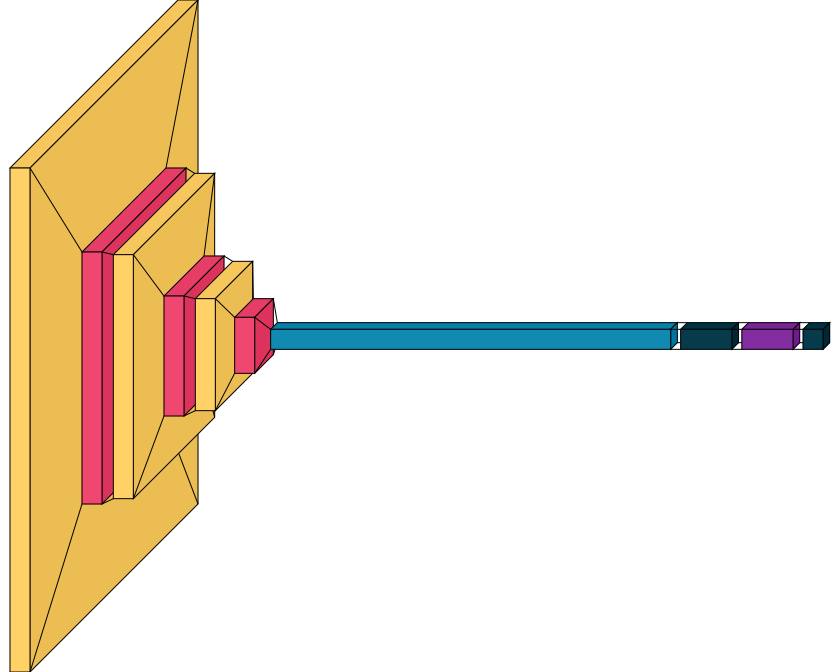

In [8]:
# Create the model
model = create_model()

# Visualize the model architecture
visualkeras.layered_view(model, draw_volume=True)

---

The code below trains the CNN using 5-fold cross validation

---

In [9]:
# Clear previous TensorFlow session
tf.keras.backend.clear_session()

# Set up ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255)

# Create a list of all files and their corresponding labels
all_files = []
all_labels = []
classes = os.listdir(base_dir)
for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            all_files.append(file_path)
            all_labels.append(class_name)

# Convert lists to numpy arrays
all_files = np.array(all_files)
all_labels = np.array(all_labels)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to store results
fold = 1
all_accuracies = []

# Perform 5-fold cross-validation
for train_index, val_index in kf.split(all_files):
    print(f"Training fold {fold}...")
    train_files, val_files = all_files[train_index], all_files[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create data generators for training and validation
    train_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
        x_col='filename',
        y_col='class',
        target_size=(128, 128),
        batch_size=16,
        class_mode='binary',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
        x_col='filename',
        y_col='class',
        target_size=(128, 128),
        batch_size=16,
        class_mode='binary',
        shuffle=True
    )

    # Create and train the model
    model = create_model()
    history = model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / train_generator.batch_size),
        validation_data=validation_generator,
        validation_steps=np.ceil(validation_generator.samples / validation_generator.batch_size),
        epochs=20
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(validation_generator)
    print(f'Fold {fold} Validation Accuracy: {accuracy * 100:.2f}%')
    all_accuracies.append(accuracy)
    fold += 1

# Calculate average accuracy across all folds
average_accuracy = np.mean(all_accuracies)
print(f'Average Validation Accuracy: {average_accuracy * 100:.2f}%')


Training fold 1...
Found 4798 validated image filenames belonging to 2 classes.
Found 1201 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
300/300 [==============================] - 12s 20ms/step - loss: 0.6093 - accuracy: 0.6499 - val_loss: 0.4557 - val_accuracy: 0.7985
Epoch 2/20
300/300 [==============================] - 5s 17ms/step - loss: 0.4223 - accuracy: 0.8041 - val_loss: 0.3731 - val_accuracy: 0.8368
Epoch 3/20
300/300 [==============================] - 5s 16ms/step - loss: 0.3381 - accuracy: 0.8562 - val_loss: 0.3180 - val_accuracy: 0.8651
Epoch 4/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2683 - accuracy: 0.8908 - val_loss: 0.2679 - val_accuracy: 0.8876
Epoch 5/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2028 - accuracy: 0.9212 - val_loss: 0.2167 - val_accuracy: 0.9092
Epoch 6/20
300/300 [==============================] - 5s 17ms/step - loss: 0.1476 - accuracy: 0.9441 - val_loss: 0.1877 - val_accuracy: 0.9267
Epoch 7/20
300/300 [==============================] - 5s 16ms/step - loss: 0.1119 - accuracy: 0.9589 - val_loss: 0.1613 - val_accuracy: 0.935

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


300/300 [==============================] - 7s 18ms/step - loss: 0.6159 - accuracy: 0.6529 - val_loss: 0.4598 - val_accuracy: 0.8015
Epoch 2/20
300/300 [==============================] - 5s 16ms/step - loss: 0.4500 - accuracy: 0.7873 - val_loss: 0.4362 - val_accuracy: 0.7965
Epoch 3/20
300/300 [==============================] - 5s 17ms/step - loss: 0.3641 - accuracy: 0.8379 - val_loss: 0.3169 - val_accuracy: 0.8657
Epoch 4/20
300/300 [==============================] - 5s 17ms/step - loss: 0.3031 - accuracy: 0.8706 - val_loss: 0.2829 - val_accuracy: 0.8799
Epoch 5/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2392 - accuracy: 0.9060 - val_loss: 0.2365 - val_accuracy: 0.9016
Epoch 6/20
300/300 [==============================] - 5s 17ms/step - loss: 0.1854 - accuracy: 0.9325 - val_loss: 0.2259 - val_accuracy: 0.9083
Epoch 7/20
300/300 [==============================] - 5s 17ms/step - loss: 0.1419 - accuracy: 0.9533 - val_loss: 0.1725 - val_accuracy: 0.9316
Epoch 8/20

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


300/300 [==============================] - 7s 18ms/step - loss: 0.5852 - accuracy: 0.6837 - val_loss: 0.4942 - val_accuracy: 0.7475
Epoch 2/20
300/300 [==============================] - 5s 17ms/step - loss: 0.4080 - accuracy: 0.8143 - val_loss: 0.4283 - val_accuracy: 0.7992
Epoch 3/20
300/300 [==============================] - 5s 17ms/step - loss: 0.3318 - accuracy: 0.8602 - val_loss: 0.3379 - val_accuracy: 0.8550
Epoch 4/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2588 - accuracy: 0.8966 - val_loss: 0.2936 - val_accuracy: 0.8750
Epoch 5/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2033 - accuracy: 0.9231 - val_loss: 0.2457 - val_accuracy: 0.9033
Epoch 6/20
300/300 [==============================] - 5s 17ms/step - loss: 0.1551 - accuracy: 0.9435 - val_loss: 0.2345 - val_accuracy: 0.9000
Epoch 7/20
300/300 [==============================] - 5s 16ms/step - loss: 0.1194 - accuracy: 0.9581 - val_loss: 0.2103 - val_accuracy: 0.9133
Epoch 8/20

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


300/300 [==============================] - 7s 18ms/step - loss: 0.5816 - accuracy: 0.6793 - val_loss: 0.4480 - val_accuracy: 0.7883
Epoch 2/20
300/300 [==============================] - 5s 17ms/step - loss: 0.4157 - accuracy: 0.8100 - val_loss: 0.3607 - val_accuracy: 0.8467
Epoch 3/20
300/300 [==============================] - 5s 17ms/step - loss: 0.3500 - accuracy: 0.8454 - val_loss: 0.2960 - val_accuracy: 0.8783
Epoch 4/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2751 - accuracy: 0.8854 - val_loss: 0.2511 - val_accuracy: 0.8925
Epoch 5/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2145 - accuracy: 0.9187 - val_loss: 0.2455 - val_accuracy: 0.8917
Epoch 6/20
300/300 [==============================] - 5s 17ms/step - loss: 0.1632 - accuracy: 0.9392 - val_loss: 0.1801 - val_accuracy: 0.9317
Epoch 7/20
300/300 [==============================] - 5s 17ms/step - loss: 0.1251 - accuracy: 0.9569 - val_loss: 0.1516 - val_accuracy: 0.9483
Epoch 8/20

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


300/300 [==============================] - 7s 18ms/step - loss: 0.6036 - accuracy: 0.6577 - val_loss: 0.4911 - val_accuracy: 0.7631
Epoch 2/20
300/300 [==============================] - 5s 17ms/step - loss: 0.4159 - accuracy: 0.8104 - val_loss: 0.4032 - val_accuracy: 0.8140
Epoch 3/20
300/300 [==============================] - 5s 17ms/step - loss: 0.3421 - accuracy: 0.8496 - val_loss: 0.3504 - val_accuracy: 0.8449
Epoch 4/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2785 - accuracy: 0.8863 - val_loss: 0.3100 - val_accuracy: 0.8649
Epoch 5/20
300/300 [==============================] - 5s 17ms/step - loss: 0.2075 - accuracy: 0.9181 - val_loss: 0.2673 - val_accuracy: 0.8882
Epoch 6/20
300/300 [==============================] - 5s 17ms/step - loss: 0.1650 - accuracy: 0.9356 - val_loss: 0.2416 - val_accuracy: 0.9041
Epoch 7/20
300/300 [==============================] - 5s 17ms/step - loss: 0.1187 - accuracy: 0.9606 - val_loss: 0.2139 - val_accuracy: 0.9066
Epoch 8/20

---

The code below displays the training history for the last fold

---

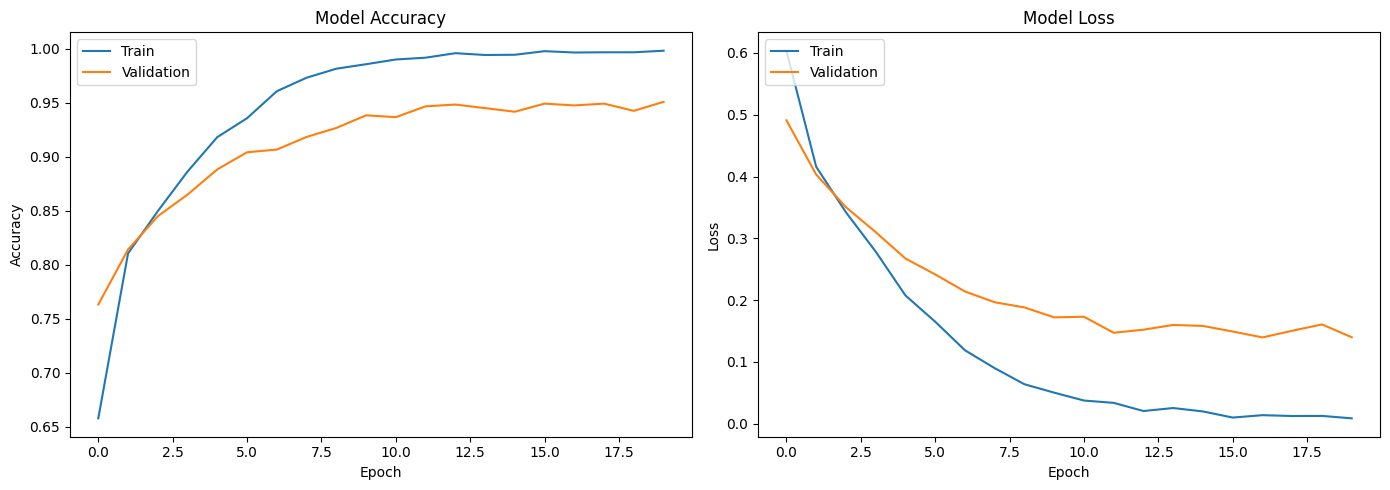

75/75 [==============================] - 1s 13ms/step - loss: 0.1398 - accuracy: 0.9508
Validation Loss: 0.1398
Validation Accuracy: 95.08%


In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

---

The code below displays the confusion matrix for the last fold

---

75/75 [==============================] - 1s 13ms/step


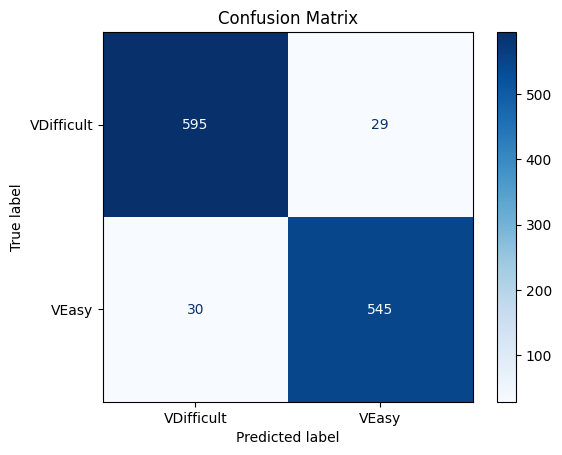

Calculated Validation Accuracy: 95.08%


In [11]:
# Ensure that the validation generator is reset
validation_generator.reset()

# Get the true labels
y_true = []
for _ in range(len(validation_generator)):
    _, labels = validation_generator.next()
    y_true.extend(labels)

# Convert y_true to a numpy array
y_true = np.array(y_true)

# Get predictions from the model
validation_generator.reset()  # Reset again to ensure matching order
y_pred = model.predict(validation_generator, steps=len(validation_generator))
y_pred = np.rint(y_pred).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Verify the accuracy
accuracy = np.sum(y_true == y_pred) / len(y_true)
print(f'Calculated Validation Accuracy: {accuracy * 100:.2f}%')

---

The code below displays predictions using the last fold

---

1/1 [==============================] - 0s 103ms/step


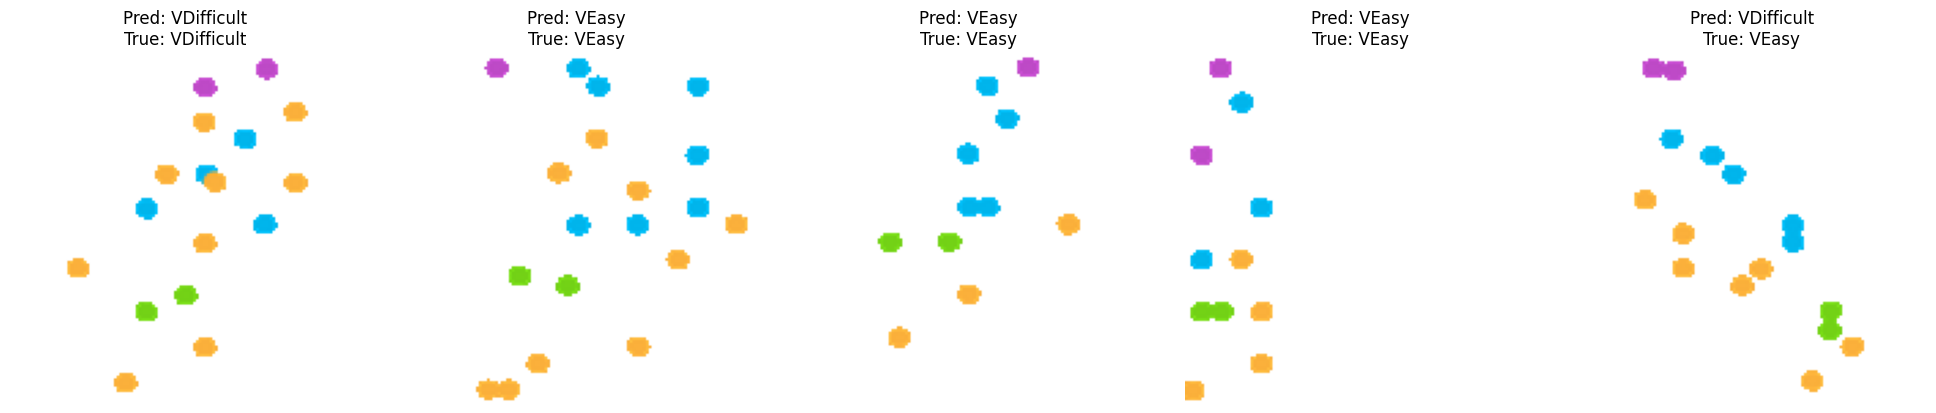

In [12]:
# Function to display images with predictions and ground truth
def display_predictions(generator, model, num_images=5):
    class_labels = list(generator.class_indices.keys())  # Get class labels
    generator.reset()  # Reset the generator to avoid shuffling issues
    batch = next(generator)  # Get a batch of images and labels
    images, labels = batch[0], batch[1]

    predictions = model.predict(images)
    predicted_classes = np.rint(predictions).astype(int).flatten()

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        true_label = class_labels[int(labels[i])]
        predicted_label = class_labels[predicted_classes[i]]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", fontsize=12)
        plt.axis('off')

    plt.tight_layout(pad=3.0)  # Adjust the spacing between subplots
    plt.show()

# Display predictions for specific validation images
display_predictions(validation_generator, model, num_images=5)

# Classifier for (64, 64)
---

The last step is to create a CNN to classify the data as easier or harder routes for 64 * 64 images

---

The code below resizes the images to 64 * 64

---

In [13]:
# Function to resize images
def resize_images(image_paths, target_size=(64, 64)):
    for image_path in image_paths:
        with Image.open(image_path) as img:
            img_resized = img.resize(target_size, Image.ANTIALIAS)
            img_resized.save(image_path)

# Resize VDifficult images
for level, image_paths in vdifficult_images.items():
    resize_images(image_paths)

# Resize VEasy images
for level, image_paths in veasy_images.items():
    resize_images(image_paths)

---

The code below re-defines the CNN for 64 * 64 input

---

In [14]:
# Function to create the model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

---

The code below trains the CNN using 5-fold cross validation

---

In [15]:
# Clear previous TensorFlow session
tf.keras.backend.clear_session()

# Set up ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(rescale=1./255)

# Create a list of all files and their corresponding labels
all_files = []
all_labels = []
classes = os.listdir(base_dir)
for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    if os.path.isdir(class_path):
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            all_files.append(file_path)
            all_labels.append(class_name)

# Convert lists to numpy arrays
all_files = np.array(all_files)
all_labels = np.array(all_labels)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize variables to store results
fold = 1
all_accuracies = []

# Perform 5-fold cross-validation
for train_index, val_index in kf.split(all_files):
    print(f"Training fold {fold}...")
    train_files, val_files = all_files[train_index], all_files[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create data generators for training and validation
    train_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': train_files, 'class': train_labels}),
        x_col='filename',
        y_col='class',
        target_size=(64, 64),
        batch_size=16,
        class_mode='binary',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': val_files, 'class': val_labels}),
        x_col='filename',
        y_col='class',
        target_size=(64, 64),
        batch_size=16,
        class_mode='binary',
        shuffle=True
    )

    # Create and train the model
    model = create_model()
    history = model.fit(
        train_generator,
        steps_per_epoch=np.ceil(train_generator.samples / train_generator.batch_size),
        validation_data=validation_generator,
        validation_steps=np.ceil(validation_generator.samples / validation_generator.batch_size),
        epochs=20
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(validation_generator)
    print(f'Fold {fold} Validation Accuracy: {accuracy * 100:.2f}%')
    all_accuracies.append(accuracy)
    fold += 1

# Calculate average accuracy across all folds
average_accuracy = np.mean(all_accuracies)
print(f'Average Validation Accuracy: {average_accuracy * 100:.2f}%')

Training fold 1...
Found 4798 validated image filenames belonging to 2 classes.
Found 1201 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/20
300/300 [==============================] - 7s 16ms/step - loss: 0.6767 - accuracy: 0.5742 - val_loss: 0.6175 - val_accuracy: 0.6553
Epoch 2/20
300/300 [==============================] - 4s 14ms/step - loss: 0.5231 - accuracy: 0.7451 - val_loss: 0.4296 - val_accuracy: 0.8177
Epoch 3/20
300/300 [==============================] - 4s 14ms/step - loss: 0.4088 - accuracy: 0.8097 - val_loss: 0.3951 - val_accuracy: 0.8360
Epoch 4/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3623 - accuracy: 0.8397 - val_loss: 0.3330 - val_accuracy: 0.8560
Epoch 5/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3085 - accuracy: 0.8724 - val_loss: 0.3010 - val_accuracy: 0.8776
Epoch 6/20
300/300 [==============================] - 4s 14ms/step - loss: 0.2644 - accuracy: 0.8927 - val_loss: 0.2651 - val_accuracy: 0.8909
Epoch 7/20
300/300 [==============================] - 4s 14ms/step - loss: 0.2182 - accuracy: 0.9148 - val_loss: 0.2721 - val_accuracy: 0.8893

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


300/300 [==============================] - 6s 15ms/step - loss: 0.6843 - accuracy: 0.5469 - val_loss: 0.6447 - val_accuracy: 0.6480
Epoch 2/20
300/300 [==============================] - 4s 14ms/step - loss: 0.5598 - accuracy: 0.7237 - val_loss: 0.4470 - val_accuracy: 0.7973
Epoch 3/20
300/300 [==============================] - 4s 14ms/step - loss: 0.4330 - accuracy: 0.8069 - val_loss: 0.4271 - val_accuracy: 0.7990
Epoch 4/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3677 - accuracy: 0.8425 - val_loss: 0.3605 - val_accuracy: 0.8257
Epoch 5/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3210 - accuracy: 0.8598 - val_loss: 0.3079 - val_accuracy: 0.8741
Epoch 6/20
300/300 [==============================] - 4s 14ms/step - loss: 0.2751 - accuracy: 0.8873 - val_loss: 0.2596 - val_accuracy: 0.9016
Epoch 7/20
300/300 [==============================] - 4s 14ms/step - loss: 0.2289 - accuracy: 0.9071 - val_loss: 0.2348 - val_accuracy: 0.9041
Epoch 8/20

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


300/300 [==============================] - 6s 15ms/step - loss: 0.6690 - accuracy: 0.5793 - val_loss: 0.5989 - val_accuracy: 0.6942
Epoch 2/20
300/300 [==============================] - 4s 15ms/step - loss: 0.5019 - accuracy: 0.7585 - val_loss: 0.4464 - val_accuracy: 0.8058
Epoch 3/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3993 - accuracy: 0.8164 - val_loss: 0.3949 - val_accuracy: 0.8217
Epoch 4/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3486 - accuracy: 0.8468 - val_loss: 0.3577 - val_accuracy: 0.8450
Epoch 5/20
300/300 [==============================] - 4s 14ms/step - loss: 0.2947 - accuracy: 0.8737 - val_loss: 0.3247 - val_accuracy: 0.8533
Epoch 6/20
300/300 [==============================] - 4s 15ms/step - loss: 0.2595 - accuracy: 0.8944 - val_loss: 0.2977 - val_accuracy: 0.8617
Epoch 7/20
300/300 [==============================] - 4s 14ms/step - loss: 0.2220 - accuracy: 0.9146 - val_loss: 0.2517 - val_accuracy: 0.8942
Epoch 8/20

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


300/300 [==============================] - 6s 15ms/step - loss: 0.6934 - accuracy: 0.5226 - val_loss: 0.6809 - val_accuracy: 0.5600
Epoch 2/20
300/300 [==============================] - 4s 14ms/step - loss: 0.6328 - accuracy: 0.6449 - val_loss: 0.5448 - val_accuracy: 0.7517
Epoch 3/20
300/300 [==============================] - 4s 14ms/step - loss: 0.4937 - accuracy: 0.7645 - val_loss: 0.4283 - val_accuracy: 0.8292
Epoch 4/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3994 - accuracy: 0.8241 - val_loss: 0.3690 - val_accuracy: 0.8400
Epoch 5/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3401 - accuracy: 0.8543 - val_loss: 0.3198 - val_accuracy: 0.8675
Epoch 6/20
300/300 [==============================] - 4s 14ms/step - loss: 0.2822 - accuracy: 0.8831 - val_loss: 0.2764 - val_accuracy: 0.8800
Epoch 7/20
300/300 [==============================] - 4s 14ms/step - loss: 0.2359 - accuracy: 0.9033 - val_loss: 0.2500 - val_accuracy: 0.9008
Epoch 8/20

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


300/300 [==============================] - 6s 14ms/step - loss: 0.6848 - accuracy: 0.5554 - val_loss: 0.6556 - val_accuracy: 0.5905
Epoch 2/20
300/300 [==============================] - 4s 15ms/step - loss: 0.5613 - accuracy: 0.7160 - val_loss: 0.4782 - val_accuracy: 0.7823
Epoch 3/20
300/300 [==============================] - 5s 15ms/step - loss: 0.4264 - accuracy: 0.8073 - val_loss: 0.4251 - val_accuracy: 0.8057
Epoch 4/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3751 - accuracy: 0.8313 - val_loss: 0.3681 - val_accuracy: 0.8357
Epoch 5/20
300/300 [==============================] - 4s 14ms/step - loss: 0.3251 - accuracy: 0.8662 - val_loss: 0.3422 - val_accuracy: 0.8407
Epoch 6/20
300/300 [==============================] - 4s 14ms/step - loss: 0.2863 - accuracy: 0.8790 - val_loss: 0.3117 - val_accuracy: 0.8732
Epoch 7/20
300/300 [==============================] - 4s 15ms/step - loss: 0.2520 - accuracy: 0.9004 - val_loss: 0.2935 - val_accuracy: 0.8774
Epoch 8/20

---

The code below displays the training history for the last fold

---

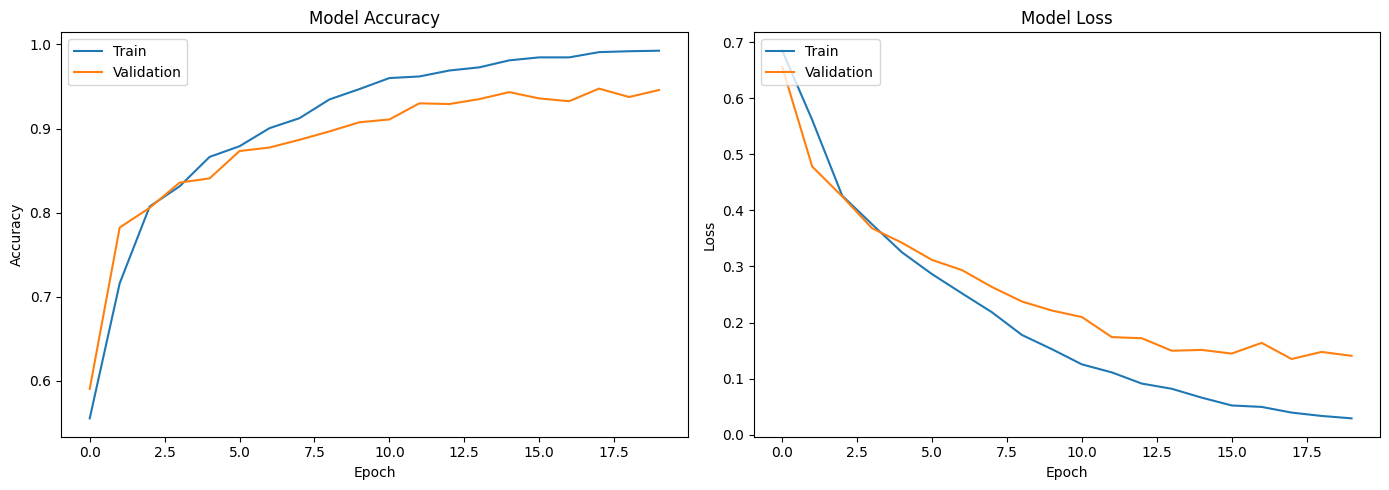

75/75 [==============================] - 1s 11ms/step - loss: 0.1406 - accuracy: 0.9458
Validation Loss: 0.1406
Validation Accuracy: 94.58%


In [16]:
# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show the plots
plt.tight_layout()
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

---

The code below displays the confusion matrix for the last fold

---

75/75 [==============================] - 1s 11ms/step


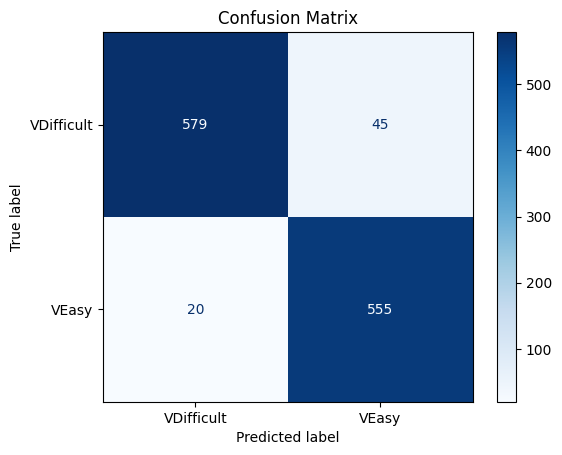

Calculated Validation Accuracy: 94.58%


In [17]:
# Ensure that the validation generator is reset
validation_generator.reset()

# Get the true labels
y_true = []
for _ in range(len(validation_generator)):
    _, labels = validation_generator.next()
    y_true.extend(labels)

# Convert y_true to a numpy array
y_true = np.array(y_true)

# Get predictions from the model
validation_generator.reset()  # Reset again to ensure matching order
y_pred = model.predict(validation_generator, steps=len(validation_generator))
y_pred = np.rint(y_pred).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Verify the accuracy
accuracy = np.sum(y_true == y_pred) / len(y_true)
print(f'Calculated Validation Accuracy: {accuracy * 100:.2f}%')

---

The code below displays predictions using the last fold

---

1/1 [==============================] - 0s 83ms/step


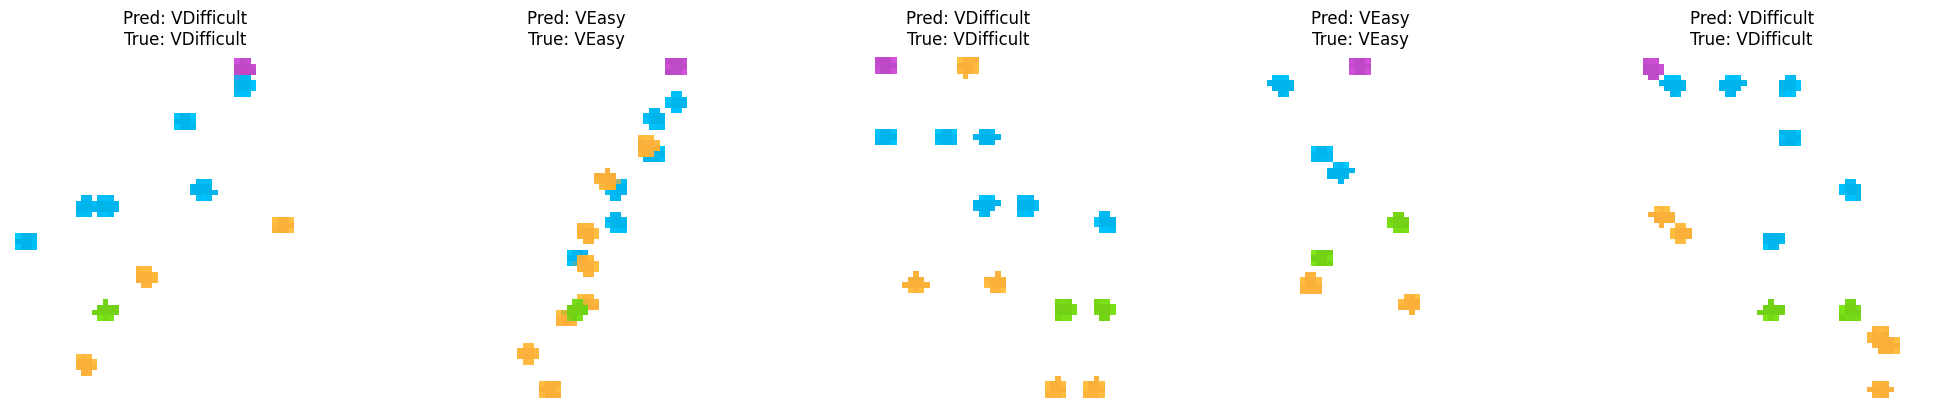

In [18]:
# Function to display images with predictions and ground truth
def display_predictions(generator, model, num_images=5):
    class_labels = list(generator.class_indices.keys())  # Get class labels
    generator.reset()  # Reset the generator to avoid shuffling issues
    batch = next(generator)  # Get a batch of images and labels
    images, labels = batch[0], batch[1]

    predictions = model.predict(images)
    predicted_classes = np.rint(predictions).astype(int).flatten()

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        true_label = class_labels[int(labels[i])]
        predicted_label = class_labels[predicted_classes[i]]
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}", fontsize=12)
        plt.axis('off')

    plt.tight_layout(pad=3.0)  # Adjust the spacing between subplots
    plt.show()

# Display predictions for specific validation images
display_predictions(validation_generator, model, num_images=5)

---

The code below re-trains the CNN on the entire dataset and saves it to a file

---

In [24]:
# Clear previous TensorFlow session
tf.keras.backend.clear_session()

# Set up ImageDataGenerator for normalization
datagen = ImageDataGenerator(rescale=1./255)

# Create data generator for training
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(64, 64),
    batch_size=16,
    class_mode='binary'
)

# Function to create the model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model on the entire dataset
model = create_model()
history = model.fit(
    train_generator,
    steps_per_epoch=np.ceil(train_generator.samples / train_generator.batch_size),
    epochs=20
)

# Save the trained model to a file
model.save('trained_classification_model_64.h5')

Found 5999 images belonging to 2 classes.
Epoch 1/20
375/375 [==============================] - 6s 11ms/step - loss: 0.6863 - accuracy: 0.5439
Epoch 2/20
375/375 [==============================] - 4s 11ms/step - loss: 0.5410 - accuracy: 0.7291
Epoch 3/20
375/375 [==============================] - 4s 12ms/step - loss: 0.4169 - accuracy: 0.8146
Epoch 4/20
375/375 [==============================] - 4s 11ms/step - loss: 0.3588 - accuracy: 0.8425
Epoch 5/20
375/375 [==============================] - 4s 11ms/step - loss: 0.3216 - accuracy: 0.8585
Epoch 6/20
375/375 [==============================] - 4s 11ms/step - loss: 0.2723 - accuracy: 0.8885
Epoch 7/20
375/375 [==============================] - 4s 11ms/step - loss: 0.2313 - accuracy: 0.9032
Epoch 8/20
375/375 [==============================] - 4s 12ms/step - loss: 0.1861 - accuracy: 0.9292
Epoch 9/20
375/375 [==============================] - 4s 11ms/step - loss: 0.1535 - accuracy: 0.9452
Epoch 10/20
375/375 [============================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#References
---

Image Credit: https://gripped.com/profiles/the-kilter-board-is-the-future-of-board-climbing/